## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import os
import joblib

import tensorflow as tf
import re
import random
import tf_keras
from tf_keras.callbacks import EarlyStopping  # Use tf.keras.callbacks
import kagglehub
import zipfile
from transformers import TFAutoModel
import shutil
from datetime import timedelta
try:
  import mplfinance as mpf
except:
  !pip install mplfinance
  import mplfinance as mpf
import io
from PIL import Image
from datetime import timedelta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 7.0 MB/s eta 0:00:00


## Downloading the data (Model Never Seen)

In [11]:
def download_and_extract_data(filename="output_latest", filename_output="output"):
    """
    Downloads, extracts, and deletes a zip file if it doesn't already exist.

    Args:
        filename: The name of the zip file to download.
        filename_output: The name of the folder to extract the contents to.
    """
    if not os.path.exists(filename_output):
        try:
            # Download the .zip file
            print(f"Downloading '{filename}'...")
            # Get the actual downloaded file path
            downloaded_file_path = kagglehub.dataset_download("sulimantadros/5-minute-multiple-pairs-with-charts")

            # Rename if necessary (if kagglehub returns a different name)
            if downloaded_file_path != filename:
                os.rename(downloaded_file_path, filename)
                print(f"Renamed downloaded file to '{filename}'")

        except Exception as e:
            print(f"An error occurred: {e}")
    else:
        print(f"File '{filename_output}' already exists. Skipping download and extraction.")

download_and_extract_data(filename="output_latest.zip", filename_output="output")

100%|██████████| 135M/135M [00:07<00:00, 18.9MB/s]

Extracting files...


Renamed downloaded file to 'output_latest.zip'


## Download and load the data it was trained on to get variables

In [3]:
def download_and_extract_data_1(filename="output_latest", filename_output="output"):
    """
    Downloads, extracts, and deletes a zip file if it doesn't already exist.

    Args:
        filename: The name of the zip file to download.
        filename_output: The name of the folder to extract the contents to.
    """
    if not os.path.exists(filename_output):
        try:
            # Download the .zip file
            print(f"Downloading '{filename}'...")
            # Get the actual downloaded file path
            downloaded_file_path = kagglehub.dataset_download("sulimantadros/updated-logic-5-minute-forex-1000-datapoints")

            # Rename if necessary (if kagglehub returns a different name)
            if downloaded_file_path != filename:
                os.rename(downloaded_file_path, filename)
                print(f"Renamed downloaded file to '{filename}'")

        except Exception as e:
            print(f"An error occurred: {e}")
    else:
        print(f"File '{filename_output}' already exists. Skipping download and extraction.")

download_and_extract_data_1(filename="output_latest_1.zip", filename_output="output")

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

# Directories
original_train_dir = '/content/output_latest_1.zip/output_updated_logic_5_minute_forex_data/output_hourly_price_action_patterns_training_and_validation/train'
original_valid_dir = '/content/output_latest_1.zip/output_updated_logic_5_minute_forex_data/output_hourly_price_action_patterns_training_and_validation/validation'
original_test_dir = '/content/output_latest_1.zip/output_updated_logic_5_minute_forex_data/output_hourly_price_action_patterns_testing/test'

# Create balanced test dataset
test_ds = tf_keras.utils.image_dataset_from_directory(
    directory=original_test_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False,
    seed=SEED
)

class_names = test_ds.class_names
file_paths = test_ds.file_paths

100%|██████████| 80.8M/80.8M [00:05<00:00, 16.6MB/s]

Extracting files...


Renamed downloaded file to 'output_latest_1.zip'
Found 3670 files belonging to 3 classes.


## Building the machine learning model

In [4]:
def count_parameters(model, print_output=True):
  """
  Counts the number of trainable, non-trainable and total parameters of a given model.
  """
  trainable_parameters = np.sum([np.prod(layer.shape) for layer in model.trainable_weights])
  non_trainable_parameters = np.sum([np.prod(layer.shape) for layer in model.non_trainable_weights])
  total_parameters = trainable_parameters + non_trainable_parameters
  if print_output:
    print(f"Model {model.name} parameter counts:")
    print(f"Total parameters: {total_parameters}")
    print(f"Trainable parameters: {trainable_parameters}")
    print(f"Non-trainable parameters: {non_trainable_parameters}")
  else:
    return total_parameters, trainable_parameters, non_trainable_parameters

In [5]:
def create_model(include_top: bool = False,
                 num_classes: int = 1000,
                 input_shape: tuple[int, int, int] = (224, 224, 3),
                 include_preprocessing: bool = True,
                 trainable: bool = False,
                 dropout: float = 0.2,
                 activation: str = "softmax",
                 base_model: tf_keras.Model = None,
                 model_name: str = "model") -> tf_keras.Model:
  """
  Create an EfficientNetV2 B0 feature extractor model with a custom classifier layer.

  Args:
      include_top (bool, optional): Whether to include the top (classifier) layers of the model.
      num_classes (int, optional): Number of output classes for the classifier layer.
      input_shape (tuple[int, int, int], optional): Input shape for the model's images (height, width, channels).
      include_preprocessing (bool, optional): Whether to include preprocessing layers for image normalization.
      trainable (bool, optional): Whether to make the base model trainable.
      dropout (float, optional): Dropout rate for the global average pooling layer.
      activation (str, optional): Activation function for the output layer.
      model_name (str, optional): Name for the created model.

  Returns:
      tf.keras.Model: A TensorFlow Keras model with the specified configuration.
  """
  if base_model is None:
    print('Base Model is None please enter the based model')
    return None

  if activation == "softmax":
    activation = tf_keras.activations.softmax
  elif activation == "sigmoid":
    activation = tf_keras.activations.sigmoid

  # Freeze the base model (if necessary)
  base_model.trainable = trainable

  # Create input layer
  inputs = tf_keras.Input(shape=input_shape, name="input_layer")

  # Create model backbone (middle/hidden layers)
  x = base_model(inputs, training=trainable)

  # Create output layer (also known as "classifier" layer)
  outputs = tf_keras.layers.Dense(
      units=num_classes,
      activation=activation,
      name="output_layer"
  )(x)

  # Connect input and output layer
  model = tf_keras.Model(inputs=inputs, outputs=outputs, name=model_name)

  return model

## Loading the machine learning model

In [6]:
# Download the model from Kaggle
model_0_loaded_path = kagglehub.model_download("sulimantadros/updated_logic_5_minute_forex_convnextxlarge_88/tensorFlow2/default")

# Move the downloaded directory to the current directory
destination_dir = "./model_0"
if not os.path.exists(destination_dir):
    shutil.move(model_0_loaded_path, destination_dir)

# Full path to the .keras model file
# Parameters
model_0_file = os.path.join(destination_dir, "1", "model_0.keras")
include_top = False
input_shape = (224, 224, 3)
include_preprocessing = True

# 1. Create a model
base_model = tf_keras.applications.ConvNeXtXLarge(
    include_top=include_top,
    weights="imagenet",
    input_shape=input_shape,
    include_preprocessing=include_preprocessing,
    pooling="max"  # Can use this instead of adding tf.keras.layers.MaxPooling2D() to the model
)
model_0_loaded_kaggle = create_model(num_classes=len(class_names), trainable=False, base_model=base_model)

# 2. Compile the model
model_0_loaded_kaggle.compile(optimizer=tf_keras.optimizers.Adam(learning_rate=0.001),
                loss=tf_keras.losses.CategoricalCrossentropy(from_logits=False),  # use from_logits=False if using an activation function in final layer
                metrics=["accuracy"])


  0%|          | 0.00/1.30G [00:00<?, ?B/s]
  0%|          | 1.00M/1.30G [00:01<29:23, 789kB/s]
  0%|          | 2.00M/1.30G [00:01<15:03, 1.54MB/s]
  0%|          | 3.00M/1.30G [00:01<09:27, 2.45MB/s]
  0%|          | 5.00M/1.30G [00:01<05:07, 4.51MB/s]
  1%|          | 7.00M/1.30G [00:01<03:20, 6.91MB/s]
  1%|          | 9.00M/1.30G [00:02<02:36, 8.86MB/s]
  1%|          | 12.0M/1.30G [00:02<01:58, 11.7MB/s]
  1%|          | 14.0M/1.30G [00:02<01:45, 13.1MB/s]
  1%|          | 16.0M/1.30G [00:02<01:38, 14.0MB/s]
  1%|▏         | 18.0M/1.30G [00:02<01:29, 15.3MB/s]
  2%|▏         | 20.0M/1.30G [00:02<01:29, 15.4MB/s]
  2%|▏         | 22.0M/1.30G [00:03<02:11, 10.4MB/s]
  2%|▏         | 25.0M/1.30G [00:03<01:54, 12.0MB/s]
  2%|▏         | 28.0M/1.30G [00:03<01:35, 14.2MB/s]
  2%|▏         | 31.0M/1.30G [00:03<01:20, 17.0MB/s]
  2%|▏         | 33.0M/1.30G [00:03<01:29, 15.1MB/s]
  3%|▎         | 35.0M/1.30G [00:03<01:25, 15.9MB/s]
  3%|▎         | 37.0M/1.30G [00:03<01:21, 16.6MB/s]
  

1393257616/1393257616 [==============================] - 61s 0us/step


In [7]:
# Load the weights
model_0_loaded_kaggle.load_weights('/content/model_0/updated_logic_5_minute_forex_1000_ConvNeXtXLarge_88.keras')

In [8]:
model_0_results = model_0_loaded_kaggle.evaluate(x=test_ds)
model_0_results

115/115 [==============================] - 78s 584ms/step - loss: 0.3213 - accuracy: 0.8864


[0.32130488753318787, 0.8863760232925415]

## Setting up the backtest and getting the signals from model



In [84]:
def process_data_for_all_pairs_with_provided_images_and_data(
    model, class_names, root_folder, output_root_folder
):
    """
    Process data for all pairs using pre-generated images and corresponding data files, make predictions,
    calculate profits, and plot results.

    Args:
        model: Pretrained TensorFlow model for predictions.
        class_names: List of class names for model predictions.
        root_folder: Path to root folder containing pair-specific subfolders with charts and data.
        output_root_folder: Path to root folder where results will be saved.
    """
    # Identify all pairs dynamically
    pairs = [
        pair for pair in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, pair))
    ]
    print(f"Found pairs: {pairs}")

    final_results = []

    for pair in pairs:
        print(f"Processing pair: {pair}")
        pair_folder = os.path.join(root_folder, pair)
        pair_charts_folder = os.path.join(pair_folder, "charts")
        pair_data_folder = os.path.join(pair_folder, "data")
        pair_output_folder = os.path.join(output_root_folder, pair)
        os.makedirs(pair_output_folder, exist_ok=True)

        pair_results = []

        # Process all images in the pair's charts folder
        for image_name in os.listdir(pair_charts_folder):
            if image_name.endswith(".png"):
                image_path = os.path.join(pair_charts_folder, image_name)

                # Find the corresponding data file
                csv_name = image_name.replace(".png", ".csv")
                file_path = os.path.join(pair_data_folder, csv_name)
                if not os.path.exists(file_path):
                    print(f"Missing corresponding CSV for {image_name}. Skipping.")
                    continue

                # Extract time from image name (assumes image name format includes timestamp)
                timestamp = image_name.split("_")[-1].replace(".png", "")

                # Read the CSV into a DataFrame
                df_timestamp = pd.read_csv(file_path)

                # Ensure the 'time' column is converted to datetime
                df_timestamp['time'] = pd.to_datetime(df_timestamp['time'])

                time = df_timestamp.iloc[-17:-5]['time'].iloc[-1]  # Select the last 12 candles

                target_size = 225

                # Load and preprocess image
                image = tf.keras.utils.load_img(path=image_path, color_mode="rgb", target_size=(224, 224))

                # Create resizing layer to resize the image
                resize = tf.keras.layers.Resizing(height=target_size,
                                                  width=target_size)

                # Turn the image into a tensor and resize it
                custom_image_tensor = resize(tf.keras.utils.img_to_array(image))

                # Add a batch dimension to the target tensor (e.g. (224, 224, 3) -> (1, 224, 224, 3))
                custom_image_tensor = tf.expand_dims(custom_image_tensor, axis=0)

                # Make a prediction with the target model
                pred_probs = model.predict(custom_image_tensor, verbose=0)
                # pred_probs = tf.keras.activations.softmax(tf.constant(pred_probs))
                pred_class = class_names[tf.argmax(pred_probs, axis=-1).numpy()[0]]
                pred_prob = pred_probs[0][tf.argmax(pred_probs, axis=-1).numpy()[0]]

                #print(pred_class)

                # Initialize DataFrame for pair results if not already
                if 'pair_results_df' not in locals():
                    pair_results_df = pd.DataFrame(columns=["symbol", "time", "predicted_class", "probability", "image_path", "file_path"])


                # Create a new DataFrame for the current result
                new_result = pd.DataFrame([{
                    "symbol": pair,
                    "time": time,
                    "predicted_class": pred_class,
                    "probability": pred_prob,
                    "image_path": image_path,
                    "file_path": file_path
                }])

                # Concatenate only if new_result is not empty
                if not new_result.empty:
                    pair_results_df = pd.concat([pair_results_df, new_result], ignore_index=True)

        # Convert results to DataFrame and save
        pair_results_df['time'] = pd.to_datetime(pair_results_df['time'], errors='coerce')
        pair_results_df = pair_results_df.sort_values(by='time', ascending=True)

        pair_results_csv = os.path.join(pair_output_folder, f"{pair}_predictions.csv")
        pair_results_df.to_csv(pair_results_csv, index=False)
        print(f"Results for {pair} saved to {pair_results_csv}")

        # Add trading logic
        starting_balance = 10000
        current_balance = starting_balance
        profits = []
        profit_dates = []

        for _, row in pair_results_df.iterrows():
            file_path = row['file_path']
            target_time = pd.to_datetime(row['time'])
            predicted_class = row['predicted_class']
            probability = row['probability']

            df = pd.read_csv(file_path)
            df['time'] = pd.to_datetime(df['time'])

            # Ensure target_time exists in the file
            if target_time not in df['time'].values:
                print(f"Time {target_time} not found in {file_path}. Skipping.")
                continue

            # Get entry and exit prices
            entry_price = df[df['time'] == target_time]['close'].values[0]
            exit_price = df['close'].iloc[-1]  # Exit at the last candle close

            # Calculate profit or loss
            if predicted_class == "bullish_breakout" and probability >= 0.95:
                profit = (exit_price - entry_price) * 100000  # Assume 1 lot (100,000 units)
            elif predicted_class == "bearish_breakout" and probability >= 0.95:
                profit = (entry_price - exit_price) * 100000
            else:
                continue  # Skip if class is not a breakout

            # Update balance and record profits
            current_balance += profit
            profits.append(current_balance)
            profit_dates.append(target_time)

        # Plot profits
        total_profit = current_balance - starting_balance
        plt.figure(figsize=(10, 6))
        plt.plot(profit_dates, profits, marker='o')
        plt.title(f"Profit Over Time for Pair: {pair} - Total Profit: £{total_profit:.2f}")
        plt.xlabel("Date")
        plt.ylabel("Account Balance (£)")
        plt.grid()
        profit_plot_path = os.path.join(pair_output_folder, f"{pair}_profit_plot.png")
        plt.savefig(profit_plot_path)
        plt.show()

        print(f"Profit plot saved to {profit_plot_path}")

        final_results.extend(pair_results)

    # Save final results to CSV
    final_results_df = pd.DataFrame(final_results)
    final_results_df['time'] = pd.to_datetime(final_results_df['time'], errors='coerce')
    final_results_df = final_results_df.sort_values(by='time', ascending=True)

    final_results_csv = os.path.join(output_root_folder, "final_predictions.csv")
    final_results_df.to_csv(final_results_csv, index=False)
    print(f"Final predictions saved to {final_results_csv}")


Found pairs: ['EURNZD', 'NZDCAD', 'NZDCHF', 'CHFJPY', 'CADCHF', 'GBPAUD', 'EURJPY', 'NZDJPY', 'EURGBP', 'EURAUD', 'AUDJPY']
Processing pair: EURNZD


<ipython-input-84-9e4668c2b0bc>:95: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pair_results_df = pd.concat([pair_results_df, new_result], ignore_index=True)


Results for EURNZD saved to /content/output_results/EURNZD/EURNZD_predictions.csv


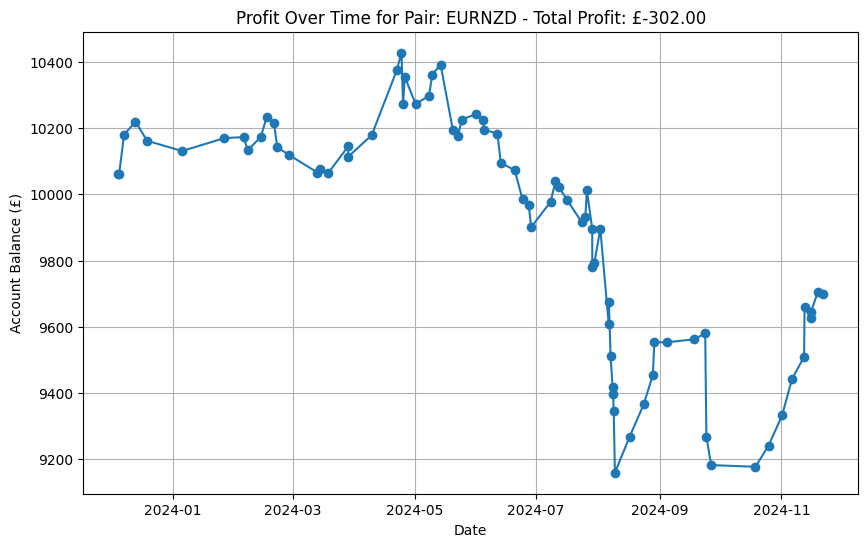

Profit plot saved to /content/output_results/EURNZD/EURNZD_profit_plot.png
Processing pair: NZDCAD
Results for NZDCAD saved to /content/output_results/NZDCAD/NZDCAD_predictions.csv


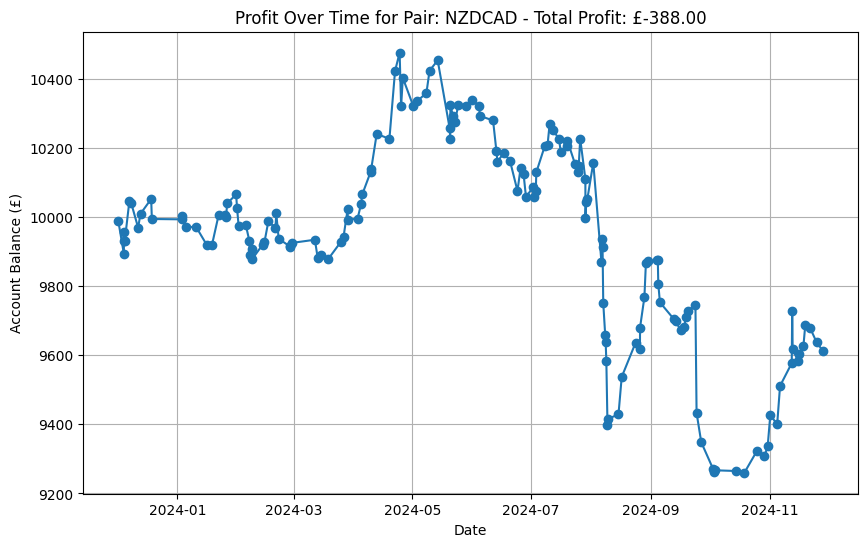

Profit plot saved to /content/output_results/NZDCAD/NZDCAD_profit_plot.png
Processing pair: NZDCHF
Results for NZDCHF saved to /content/output_results/NZDCHF/NZDCHF_predictions.csv


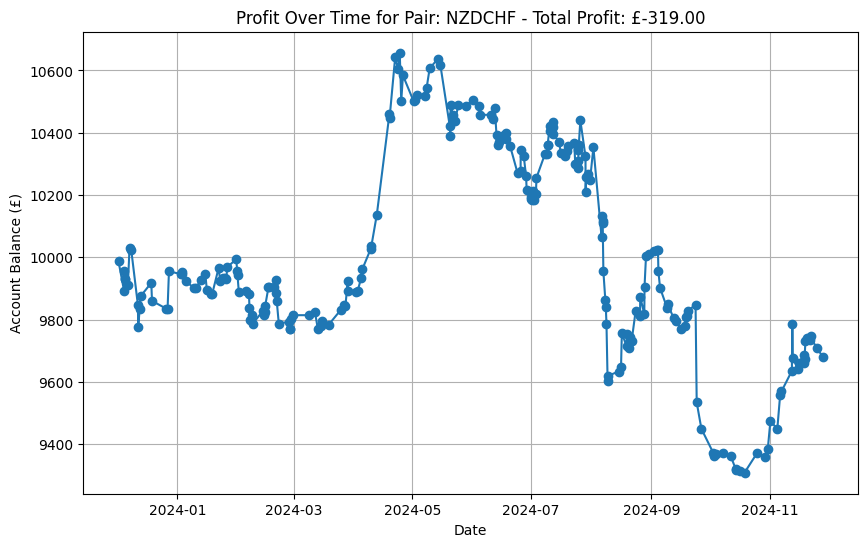

Profit plot saved to /content/output_results/NZDCHF/NZDCHF_profit_plot.png
Processing pair: CHFJPY


KeyboardInterrupt: 

In [85]:
# Example usage
data_root = "/content/output_latest.zip/output_specific_symbols_multiple_pairs_with_charts"
output_root = "/content/output_results"
process_data_for_all_pairs_with_provided_images_and_data(
    model=model_0_loaded_kaggle, class_names=class_names, root_folder=data_root, output_root_folder=output_root
)